## Lab 9: Image Classification

This lab is also written in Python, using JupyterLab. I strongly prefer to use Python for image classification, since Python is superior in terms of implementing deep learning models, which yield the best performance for classifying images. (You'll notice, if you experiment with deep learning in R, that sources will tell you to download Python and run it in the backend. Using Python directly instead just saves time and performs more smoothly.)

The datasets we work with in this lab are collections of images. As such, they take up a fair amount of space. The collections of vegetable images alone (including training set, validation set, and testing set) are almost 600 megabytes, uncompressed. Since GitHub limits the size of files that can be uploaded to a repository, I have instead posted the .zip files containing the images for this lab to our course Canvas page.

We will work with two datasets in this lab, both of which were downloaded from Kaggle. (You'll find the links for them in the references section at the bottom of the document.) The first dataset is the [Vegetable Image Dataset](https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset), sourced from a paper (Ahmed, Mamun, & Asif, 2021). The dataset consists of images of 15 different types of common vegetables found throughout the world. There are $21,000$ images total, with $1,400$ of each class (a balanced dataset). The images are of size 224 x 224 and in JPEG format. The goal is to train a neural network that can accurately classify the type of vegetable shown given an image.

[The second dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification) consists of images of natural scenes around the world. There are six categories -- "buildings," "forest," "glacier," "mountain," "sea," and "street." There are around $25,000$ images total, each of size 150 x 150 and in JPEG format. The goal is to train a neural network that can classify the subject of the image.

### Classifying Vegetables

In [164]:
# !pip install tensorflow
# !pip install opencv-python
# Uncomment and run the above lines if necessary.

We begin by importing a number of essential libraries that will be used throughout the project. First, **NumPy** is imported as `np`, a powerful library for numerical computing, which is particularly useful for handling arrays and matrices. **Matplotlib.pyplot** is imported as `plt`, which will help in visualizing data and model results. Additionally, **pandas** is imported as `pd`, a library widely used for data manipulation and analysis, which will be helpful for working with structured data, like dataframes.

The next import is **TensorFlow**, brought in as `tf`, which is an open-source machine learning framework essential for building and training deep learning models. Keras is then imported from TensorFlow, serving as a high-level API that simplifies the creation and training of neural networks. Along with Keras, all the layers required to build models are imported using `from keras.layers import *`, enabling easy access to essential components like `Dense`, `Conv2D`, and others.

For defining and training machine learning models, the necessary tools are imported from Keras through `from keras.models import *`. The image module from Keras is also imported to assist with processing and loading image data. Additionally, the `ImageDataGenerator` class is imported from `tensorflow.keras.preprocessing.image`, which will be used for augmenting image data during training to enhance model generalization.

Lastly, the **os** and **shutil** modules are imported. The **os** module allows interaction with the operating system, especially for tasks like handling file paths, while **shutil** is used for high-level file operations such as copying and moving files. The **warnings** module is also imported, with a specific call to `warnings.filterwarnings('ignore')` to suppress any warnings that might appear during execution, keeping the output clean.

In [175]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, shutil
import warnings
warnings.filterwarnings('ignore')

Now we define paths to the training, validation, and test datasets. The variable `train_path` is assigned the file path `"data/Vegetable Images/train"`, which points to the directory containing subdirectories of images used for training the model. Similarly, `validation_path` and `test_path` are created.

The next line of code assigns to the variable `image_categories` the list of directories found in the `train` folder. Using `os.listdir("data/Vegetable Images/train")`, the code retrieves all the subdirectories in the training data folder, which represent the different image categories (here, the types of vegetables). This list will help in organizing the data and labeling it for model training.

In [176]:
train_path = "data/Vegetable Images/train"
validation_path = "data/Vegetable Images/validation"
test_path = "data/Vegetable Images/test"

image_categories = os.listdir("data/Vegetable Images/train")

We can print the list of image categories below, to double-check that everything was read in correctly:

In [177]:
image_categories

['Capsicum',
 'Radish',
 'Pumpkin',
 'Cauliflower',
 'Potato',
 'Bean',
 'Cucumber',
 'Brinjal',
 'Cabbage',
 'Broccoli',
 'Bitter_Gourd',
 'Papaya',
 'Bottle_Gourd',
 'Tomato',
 'Carrot']

Now let's define a function called `plot_images`, which takes `image_categories` as input and visualizes the first image from each category in the dataset.

The function starts by creating a figure for plotting with a specified size, using `plt.figure(figsize=(12, 12))`. We then initiate a loop to iterate over each category in `image_categories`, with `i` being the index and `cat` being the name of the category (each specific vegetable type).

For each category, the code constructs the path to the images in that category by combining `train_path` and the category name. It then lists all the files in the folder corresponding to that category using `os.listdir(image_path)` and selects the first image in the folder with `first_image_of_folder = images_in_folder[0]`. The full path to this first image is created and loaded into memory using `image.load_img(first_image_path)`. The image is converted into an array format suitable for plotting, and then normalized by dividing by $255.0$ so that the resulting pixel values are between $0$ and $1$.

Next, we create a subplot using `plt.subplot(4, 4, i+1)` to arrange the images in a grid (4 rows and 4 columns). Each image is displayed using `plt.imshow(img_arr)`, with its corresponding category name set as the title (`plt.title(cat)`). The axis is turned off with `plt.axis('off')` to avoid cluttering the visualization with tick marks, which would not be useful or informative.

Finally, the `plt.show()` command is called to render and display the figure with all the plotted images.

In [178]:
def plot_images(image_categories):

    # create a figure
    plt.figure(figsize=(12, 12))
    for i, cat in enumerate(image_categories):

        # load images for the ith category
        image_path = train_path + '/' + cat
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder
        img = image.load_img(first_image_path)
        img_arr = image.img_to_array(img)/255.0

        # create subplot and plot the images
        plt.subplot(4, 4, i+1)
        plt.imshow(img_arr)
        plt.title(cat)
        plt.axis('off')

    plt.show()

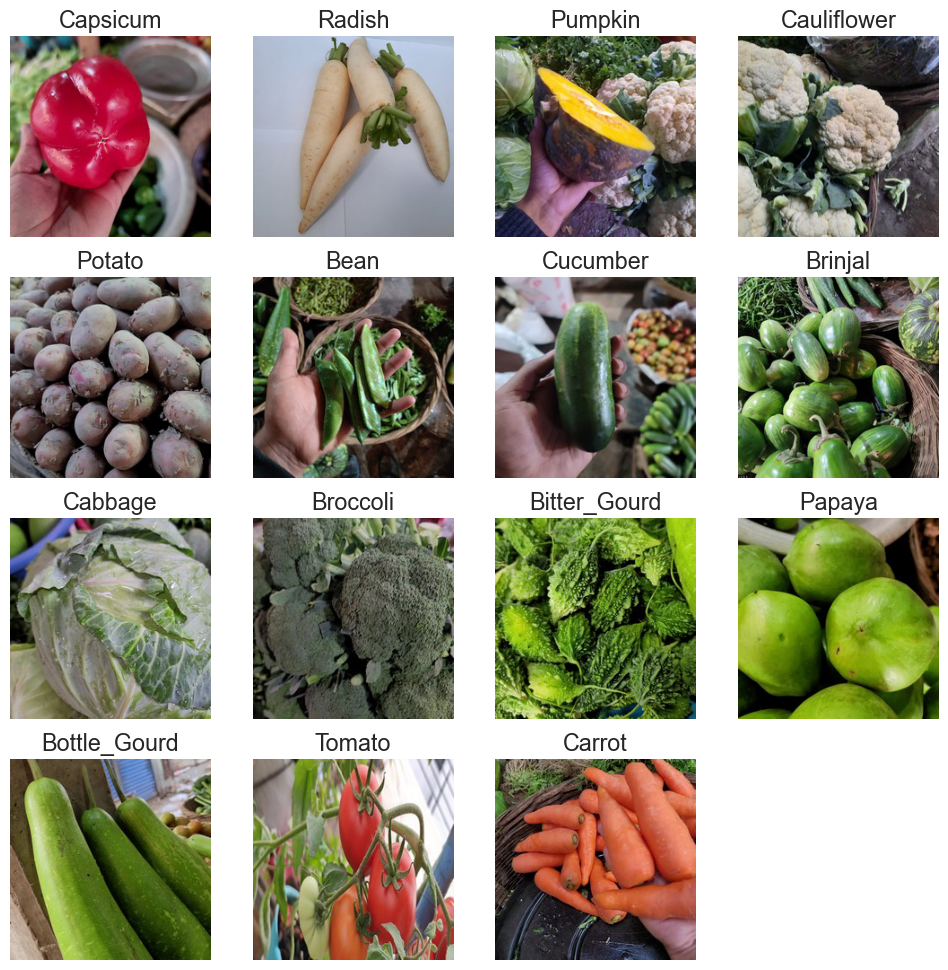

In [179]:
# call the function
plot_images(image_categories)

We can see that these images are fairly representative of their vegetable categories!

Now we'll set up data generators for loading and preprocessing images for the training, validation, and testing datasets using the `ImageDataGenerator` class from Keras.

For the training set, a `train_gen` object is created using `ImageDataGenerator(rescale=1.0/255.0)`. This code normalizes the pixel values of the images to scale them to a range of `[0, 1]`. This is an essential preprocessing step when working with neural networks, as it helps improve the stability and performance of the training process. Each image is represented as a 3D array of pixel intensities, with values ranging from $0$ to $255$. Dividing the arrays by $255.0$ converts these values into a normalized range, where $0$ corresponds to black, and $1$ corresponds to white. Intermediate values represent shades of gray or colors scaled within this range.

By normalizing the data, the model benefits in several ways:

- Improved convergence: Neural networks often converge faster when input data is on a consistent scale.
- Reduced sensitivity: The normalization reduces sensitivity to the scale of input features, preventing large pixel values from dominating smaller ones.
- Enhanced numerical stability: Lower values help avoid numerical issues during computations, especially when gradients are calculated during backpropagation.

`train_image_generator` is then created using the `flow_from_directory` method, which loads images from the specified `train_path`. The images are resized to 150 x 150 pixels using `target_size=(150, 150)` argument, and they are grouped into batches of 32 using `batch_size=32`. The `class_mode='categorical'` argument indicates that the labels are categorical (i.e., the model will predict one of several vegetable classes).

Similarly, for the validation set, a `val_gen` object is created with the same scaling factor. The `val_image_generator` is initialized to load and preprocess images from the `validation_path` directory. The validation images are also resized, batched, and labeled.

Finally, the test set is handled in the same way as the training and validation sets.

These generators will be used later in the training process to feed data to the model, ensuring that images are properly scaled and preprocessed before they are passed through the neural network.

In [180]:
# Training set
train_gen = ImageDataGenerator(rescale = 1.0/255.0) # scale the data
train_image_generator = train_gen.flow_from_directory(train_path, 
                                                      target_size=(150, 150), 
                                                      batch_size=32, 
                                                      class_mode='categorical')

# Validation set
val_gen = ImageDataGenerator(rescale = 1.0/255.0) # scale the data
val_image_generator = train_gen.flow_from_directory(validation_path, 
                                                    target_size=(150, 150), 
                                                    batch_size=32, 
                                                    class_mode='categorical')

# Testing set
test_gen = ImageDataGenerator(rescale = 1.0/255.0) # scale the data
test_image_generator = train_gen.flow_from_directory(test_path, 
                                                     target_size=(150, 150), 
                                                     batch_size=32, 
                                                     class_mode='categorical')

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


Next we create a dictionary called `class_map`, which maps the integer labels back to their corresponding category names.

The `train_image_generator.class_indices` attribute is a dictionary that contains the mapping of class names (as keys) to integer labels (as values). However, in many machine learning task, it is useful to have a reverse mapping, where the integer labels are keys and the class names are values. This is exactly what this code does.

The line `dict([(v, k) for k, v in train_image_generator.class_indices.items()])` uses a list comprehension to reverse the keys and values of the `class_indices` dictionary. It iterates over each key-value pair in `train_image_generator.class_indices.items()`, swapping the positions of the key ($k$) and value ($v$). The resulting list of tuples is then converted into a dictionary, which is assigned to `class_map`.

Finally, we call `print(class_map)` to display this new mapping. This allows us to see which integer corresponds to each class, or vegetable category:

In [181]:
# Print the class encodings by the generators:
class_map = dict([(v, k) for k, v in train_image_generator.class_indices.items()])
print(class_map)

{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


Now we'll actually create the structure for the model. The following chunk of code defines a Convolutional Neural Network (CNN) using Keras' Sequential model. The model consists of a series of layers designed to process image data for classification.

We starts by creating a `Sequential` object with `model = Sequential()`, which represents a linear stack of layers. The first layer added is a 2D Convolutional Layer (`Conv2D`), which applies convolution operations to the input images. This layer has 32 filters (or feature detectors), each with a 3 x 3 kernel. The `strides=1` argument specifies that the filter should move one pixel at a time, and `padding='same'` ensures the output image has the same width and height as the input. The activation function is set to ReLU ('`relu`'), which introduces non-linearity to the model. `input_shape=[150, 150, 3]` specifies that the input images are 150 x 150 pixels with 3 color channels (RGB).

Following the first convolutional layer, a `MaxPooling2D` layer is added, which performs downsampling by taking the maximum value over a 2 x 2 window. This reduces the spatial dimensions (the height and width) of the feature map while retaining important information. Another `Conv2D` layer with 64 filters and the same kernel size follows, further extracting features from the images. Another `MaxPooling2D` layer is applied after this, to reduce the size yet again.

Next, the feature map is flattened using the `Flatten()` layer. This transforms the 2D feature map into a 1D vector, which can be fed into fully connected layers.

We then add these fully-connected layers. The first `Dense` layer has 128 units and uses ReLU as the activation function, which helps the network learn non-linear relationships. A `Dropout` layer is added next with a rate of $0.25$, meaning that 25% of the neurons will be randomly "dropped" during training to prevent overfitting. Another `Dense` layer with 128 units follows, again with ReLU activation.

Finally, the output layer is added with a `Dense` layer of 15 units, corresponding to the 15 possible classes in the dataset (representing the 15 different types of vegetables we want to predict). The `activation='softmax'` function is used here, which is suitable for multiclass classification, since it outputs probabilities for each class.

The `model.summary()` function is called to print out the model architecture, so we can check the details, such as the number of parameters in each layer and the overall structure.

In [182]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, strides=1, 
                 padding='same', activation='relu', 
                 input_shape=[150, 150, 3]))
model.add(MaxPooling2D(2, ))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, 
                 padding='same', activation='relu'))
model.add(MaxPooling2D(2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(15, activation='softmax'))

# print the model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │    11,214,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,252,815 (42.93 MB)

 Trainable params: 11,252,815 (42.93 MB)

 Non-trainable params: 0 (0.00 B)

The only thing left to do is fit the model!

In the next chunk of code, the model is compiled and trained using `fit`. Before training begins, an **EarlyStopping** callback is defined with `early_stopping = keras.callbacks.EarlyStopping(patience=5)`. This callback monitors the validation loss during training and will stop the process early if the validation loss does not improve for 5 consecutive epochs (specified by `patience=5`). This helps prevent overfitting and can save time if the model stops improving.

We then compile the model using `model.compile()`. The optimizer used is "Adam," which is an adaptive learning rate optimization algorithm commonly used for training deep learning models. The Adam optimizer combines the advantages of two other popular optimization algorithms: AdaGrad and RMSProp. It adjusts the learning rate during training based on estimates of first and second moments of the gradients, helping the model converge faster and more efficiently.

The loss function is set to categorical crossentropy, which is appropriate for multi-class classification tasks like this one, where each label represents one of several categories. The metric used to evaluate the model’s performance is accuracy, which will track the average number of times that the predicted class matches the true class.

Next, the model is trained. The training data is provided by `train_image_generator`, and the number of epochs is set to 2. During training, the `validation_data=val_image_generator` argument specifies that the validation data is taken from the validation image generator, which allows the model to evaluate its performance on unseen data at the end of each epoch.

The `steps_per_epoch=15000//32` argument specifies how many steps (or batches) are processed per epoch, calculated by dividing the total number of training images (15,000) by the batch size (32). Similarly, `validation_steps=3000//32` specifies how many validation steps to run, based on the size of the validation dataset (3,000 images). The `verbose=1` argument ensures that training progress is displayed in the console.

Finally, the `early_stopping` callback is passed to the callbacks argument, so training will stop early if the validation performance doesn’t improve after 5 epochs.

Note that $5$ is a **very** small number of epochs. Ideally, to get really good performance from a model like this, you might want to allow the network to run for at least $50$ to $100$ epochs. However, running this code also takes a while. I've reduced the number of epochs all the way down to $5$ to get the model to run quickly for this lab. Surprisingly, even with only $5$ epochs, it actually gets pretty good performance.

In [183]:
early_stopping = keras.callbacks.EarlyStopping(patience=5)

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_image_generator, epochs=5, verbose=1, 
                 validation_data=val_image_generator, 
                 steps_per_epoch=15000//32, validation_steps=3000//32, 
                 callbacks=early_stopping)

Epoch 1/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 207s 438ms/step - accuracy: 0.4140 - loss: 1.8415 - val_accuracy: 0.8454 - val_loss: 0.5270
Epoch 2/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step - accuracy: 0.7500 - loss: 0.8614 - val_accuracy: 0.6667 - val_loss: 1.1409
Epoch 3/5


2024-11-24 17:46:53.759185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-24 17:46:53.896682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


468/468 ━━━━━━━━━━━━━━━━━━━━ 198s 422ms/step - accuracy: 0.8246 - loss: 0.5372 - val_accuracy: 0.8995 - val_loss: 0.3284
Epoch 4/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 224us/step - accuracy: 0.8750 - loss: 0.2820 - val_accuracy: 0.7917 - val_loss: 0.3909
Epoch 5/5


2024-11-24 17:50:11.859391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-24 17:50:11.952178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


468/468 ━━━━━━━━━━━━━━━━━━━━ 195s 416ms/step - accuracy: 0.8980 - loss: 0.3191 - val_accuracy: 0.9362 - val_loss: 0.2161


We can visualize the model's training and validation performance by plotting the loss and accuracy over epochs.

The history of the training process is stored in `hist.history`. This dictionary contains metrics like training loss (h['loss']), validation loss (h['val_loss']), training accuracy (h['accuracy']), and validation accuracy (h['val_accuracy']), recorded at the end of each epoch.

The training loss is plotted in red, and the validation loss is added as a dashed red line. Similarly, training accuracy is plotted in blue, and validation accuracy is displayed as a dashed blue line. Ideally, training and validation loss should decrease, and accuracy should increase over epochs. Divergences between training and validation metrics could indicate overfitting.

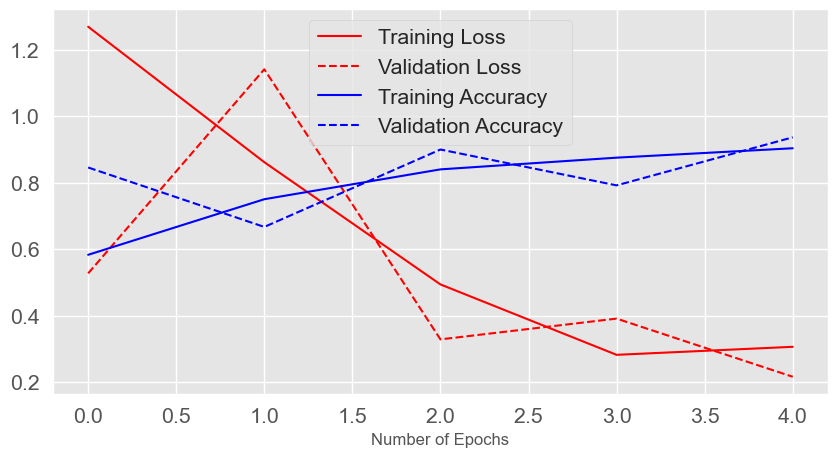

In [185]:
# plot the error and accuracy
h = hist.history
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')
plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')
plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

Since we've run a very, very small number of epochs, you may not see distinct patterns here. If we allowed it to run for more epochs, though, we would see loss begin to decrease, while accuracy would increase still further.

Now we'll evaluate the performance of the trained model on the test dataset using `model.evaluate()`. `test_image_generator` is passed as an argument, which provides the test images and their corresponding labels to the model for evaluation.

During evaluation, the model processes each batch of test images, computes the predictions, and compares them to the true labels to calculate the test loss and metrics (such as accuracy, as specified during model compilation). The method returns these metrics as a result.

In [186]:
# predict the test set to check accuracy
model.evaluate(test_image_generator)

94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.9264 - loss: 0.2387


[0.21581366658210754, 0.9363333582878113]

An accuracy of **92.64\%** on the testing set is pretty darn good, even with only 5 epochs!

For fun, let's select one of the images in the test dataset and verify that our model can identify it correctly. We'll select one of the radishes, number $1046$. We write a function called `generate_predictions` that will take the path to an image and the true label of that image (`actual_label`) as input.

First, the image is loaded and preprocessed. The `image.load_img` function reads the image from the specified `test_image_path` and resizes it to 150 x 150 pixels (the same size the model was trained on) using `target_size=(150, 150)`. The image is then converted into an array format suitable for input to the model using `image.img_to_array`, and its pixel values are normalized by dividing by $255.0$. The resulting array is reshaped using `.reshape` to match the model's expected input shape, with the batch size set to $1$.

The model then makes a prediction using `model.predict(test_img_input)`. The output of the prediction is an array of probabilities for each class. `np.argmax` is used to find the index of the class with the highest probability, which corresponds to the predicted label. This predicted label is mapped back to its corresponding vegetable name using the `class_map` dictionary.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


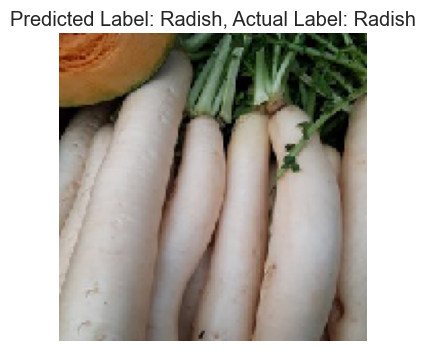

In [188]:
test_image_path = "data/Vegetable Images/test/Radish/1046.jpg"

def generate_predictions(test_image_path, actual_label):

    # load and preprocess the image
    test_img = image.load_img(test_image_path, target_size=(150, 150))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], 
                                           test_img_arr.shape[1], test_img_arr.shape[2]))

    # make predictions
    predicted_label = np.argmax(model.predict(test_img_input))
    predicted_vegetable = class_map[predicted_label]
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_vegetable, 
                                                             actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()

# call the function
generate_predictions(test_image_path, actual_label='Radish')

It did pretty well -- at least, it correctly identified that as a radish!

It might be fun to test whether it can still correctly identify a random image of a vegetable from the Internet. I downloaded a picture of green beans and stored it in the data directory, then below, we apply the `generate_predictions` function to that image:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


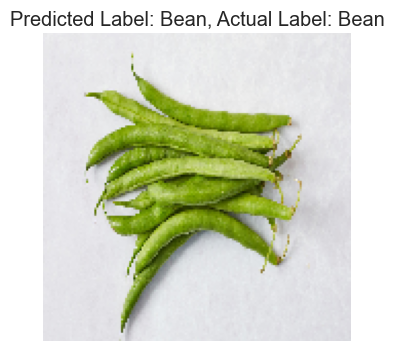

In [189]:
test_image_path = "data/Vegetable Images/online_pic_of_beans.jpg"

# call the function
generate_predictions(test_image_path, actual_label='Bean')

And lo and behold, we correctly identify the picture as a picture of beans!

#### Exercises

1. Try running the model for more epochs (i.e., do `epochs=10` instead). What patterns do you notice in terms of loss and accuracy?
2. See what happens if you remove the `Dropout` layer. Then see what happens if you increase the proportion of dropout, from $0.25$ to $0.75$.
3. Find another image of one of these 15 types of vegetables and see what your model predicts for your new image.

### Classifying Landscape Scenes

Below, we import some additional libraries. The `confusion_matrix` function from `sklearn.metrics` is imported to compute a confusion matrix.  The `seaborn` library, imported as `sn`, is used for creating plots. The font size for Seaborn visualizations is adjusted with `sn.set(font_scale=1.4)` to improve the readability of generated plots. The `shuffle` function from `sklearn.utils` is also imported to randomize data, ensuring that any potential bias from ordered data is eliminated during analysis or visualization. The `cv2` library (`OpenCV`) is included for image processing tasks, such as reading, resizing, or augmenting image data. This functionality can be helpful when preparing images for testing or visualization.

Finally, the `tqdm` library is brought in to add progress bars to loops or time-consuming tasks, enabling us to track the status of lengthy operations visually.

In [190]:
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import cv2
from tqdm import tqdm

Now we initializes key variables and mappings. First, the `class_names` list defines the categories that we intend to classify. In this case, the six classes are `'mountain', 'street', 'glacier', 'buildings', 'sea'`, and `'forest'`. These represent the labels for the dataset. A dictionary called `class_names_label` is created to map each class name to a unique numeric identifier. The dictionary comprehension `{class_name: i for i, class_name in enumerate(class_names)}` assigns an index to each class name in the order they appear in the class_names list. For example, `'mountain'` is mapped to $0$, `'street'` to $1$, and so on.

The variable `nb_classes` is defined as the length of the `class_names` list, representing the total number of classes in the dataset. This value is later used in setting up the model's output layer to ensure it has the correct number of nodes for classification. Lastly, the `IMAGE_SIZE` variable is set to `(150, 150)`, indicating the dimensions to which all input images will be resized. This ensures consistency in input size across the dataset and aligns with the dimensions expected by the model.

In [191]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

We'll write a `load_data` function to load the images and labels from the folders. The function is designed to load and preprocess image data from the specified directories for training and testing. It outputs a list containing the processed images and their corresponding labels. We begin by defining a list of datasets, `datasets`, containing paths to the training and test data directories. These directories are organized into subfolders, with each subfolder representing a class and containing images belonging to that class. An empty list, `output`, is initialized to store the processed data for both datasets.

The function then iterates through each dataset in the `datasets` list. For each dataset, two empty lists, `images` and `labels`, are created to hold the images and their corresponding class labels. Inside the loop, the function prints a message indicating the dataset being loaded. It then iterates through the subfolders in the dataset directory using `os.listdir(dataset)`. Each subfolder corresponds to a class, and its name is mapped to a numerical label using the `class_names_label` dictionary. For each image file within a subfolder, the full path to the image is constructed using `os.path.join`. The image is then read using `cv2.imread(img_path)`, converted from BGR to RGB format using `cv2.cvtColor(image, cv2.COLOR_BGR2RGB)`, and resized to the dimensions specified by the `IMAGE_SIZE` variable (150 x 150 pixels) using `cv2.resize`.

The preprocessed image is appended to the `images` list, and its corresponding label is appended to the `labels` list. The `tqdm` library is used to display a progress bar while iterating through the images, providing real-time feedback on the loading process. Once all the images and labels from a dataset are processed, the `images` and `labels` lists are converted into NumPy arrays with specific data types (`float32` for images and `int32` for labels) to ensure compatibility. These arrays are then added to the output list.

After processing both datasets, the function returns the output list, which contains tuples of `(images, labels)` for the training and test datasets. This function efficiently prepares the data for input into a neural network.

In [192]:
def load_data():

    datasets = ["data/Landscape Images/seg_train/seg_train", 
                "data/Landscape Images/seg_test/seg_test"]
    output = []

    # iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # open and resize the image
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')

        output.append((images, labels))

    return(output)

We then apply the `load_data()` function we just wrote to process the training and testing images, getting them ready for model fitting:

In [193]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading data/Landscape Images/seg_train/seg_train


100%|██████████| 2274/2274 [00:02<00:00, 1065.64it/s]


Loading data/Landscape Images/seg_test/seg_test


100%|██████████| 510/510 [00:00<00:00, 1556.93it/s]


Next, we shuffle the training data to ensure that the model receives the images in a randomized order during training. We use the `shuffle` function from `sklearn.utils`, which takes the `train_images` and `train_labels` arrays as inputs, along with a `random_state` parameter to control the randomness. The `train_images` array contains the preprocessed image data, while the `train_labels` array contains the corresponding class labels. Shuffling these arrays together ensures that the relationship between each image and its label is maintained while reordering the data. This randomness prevents the model from learning patterns based on the order of the data, which could lead to overfitting or biases.

The `random_state` parameter is set to $25$, which seeds the random number generator. This ensures that the shuffling is reproducible; each time the code is run with the same seed, the data will be shuffled in the exact same way. This is useful for debugging and comparing results across different runs. By shuffling the data, the model can potentially generalize better and avoid being influenced by any inherent ordering in the dataset, such as grouped images of specific classes.

In [194]:
train_images, train_labels = shuffle(train_images, 
                                     train_labels, 
                                     random_state=25)

Before we proceed with visualizations and modeling, we'll print out a few quick summary statistics just to verify that everything was loaded correctly. We use the first dimension of `train_labels` and `test_labels` to check the number of images in the training and testing sets, and then verify that `IMAGE_SIZE` is correct:

In [195]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


Let's take a look at the distribution of the outcome variable (class labels) in the training and testing sets before we proceed.

We use the `np.unique` function to calculate the counts of each class label. The function returns two outputs: the unique class labels (ignored here with `_`) and their respective counts, which are stored in `train_counts` and `test_counts`. We then generate a grouped bar chart, with each class displayed on the x-axis and the corresponding counts from the training and testing datasets. 

The goal here is to determine whether the datasets are imbalanced. If some classes have significantly fewer examples than others, it might indicate the need for techniques like data augmentation, resampling, or weighted loss functions to address potential biases in the model's learning process.

Although there are fewer observations in the testing set than in the training set (which makes sense), the counts for each class label are fairly balanced. There are slightly fewer `buildings`, but not so few that it should be a concern.

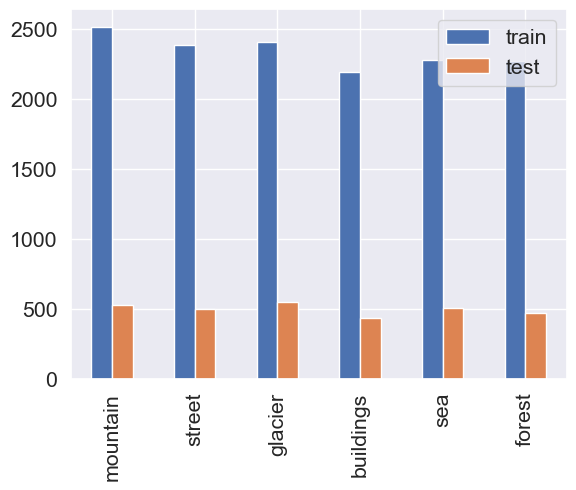

In [196]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts, 'test': test_counts}, index=class_names).plot.bar()
plt.show()

To see this pattern within the training dataset specifically, we could also make a pie chart. `explode` is set to a tuple of zeros, meaning that no slices of the pie should be "exploded" or pulled away from it. That can be useful if you want to emphasize specific slices, but isn't necessary here. The `autopct='%1.1f%'` argument says that we want the percentages displayed rounded to one decimal place.

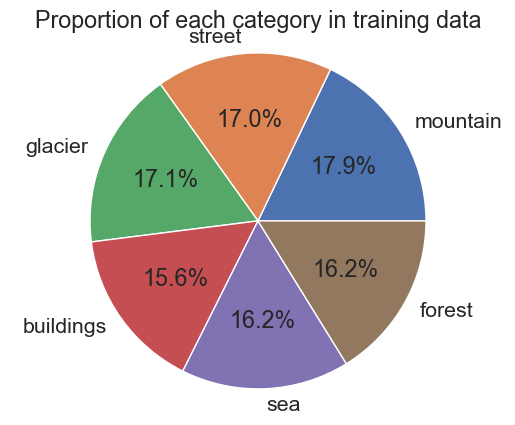

In [197]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0),
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each category in training data')
plt.show()

This code normalizes the pixel values of the images in the training and testing datasets to scale them to a range of `[0, 1]`(as described earlier in the lab).

In [198]:
# scaling the data
train_images = train_images / 255.0
test_images = test_images / 255.0

Let's display a randomly selected image from the dataset. We write a quick function, `display_random_image`, to do that. The function begins by generating a random index using `np.random.randint(images.shape[0])`. The image is shown as-is, with its pixel intensities already scaled. 

This function is useful for exploring the dataset and ensuring that the images align with their intended categories before training the model.

In [199]:
def display_random_image(class_names, images, labels):

    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

We call the function, and it seems to be working:

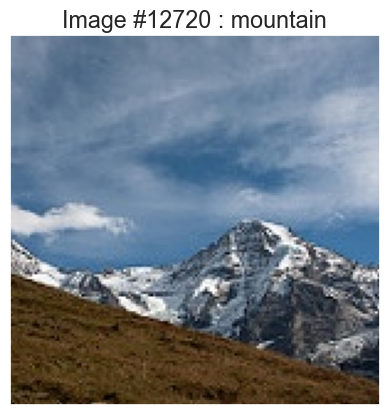

In [212]:
display_random_image(class_names, train_images, train_labels)

We write a similar function, `display_examples`, that plots the first 25 images, along with their labels:

In [213]:
def display_examples(class_names, images, labels):
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("The first 25 images:", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

Let's look at them:

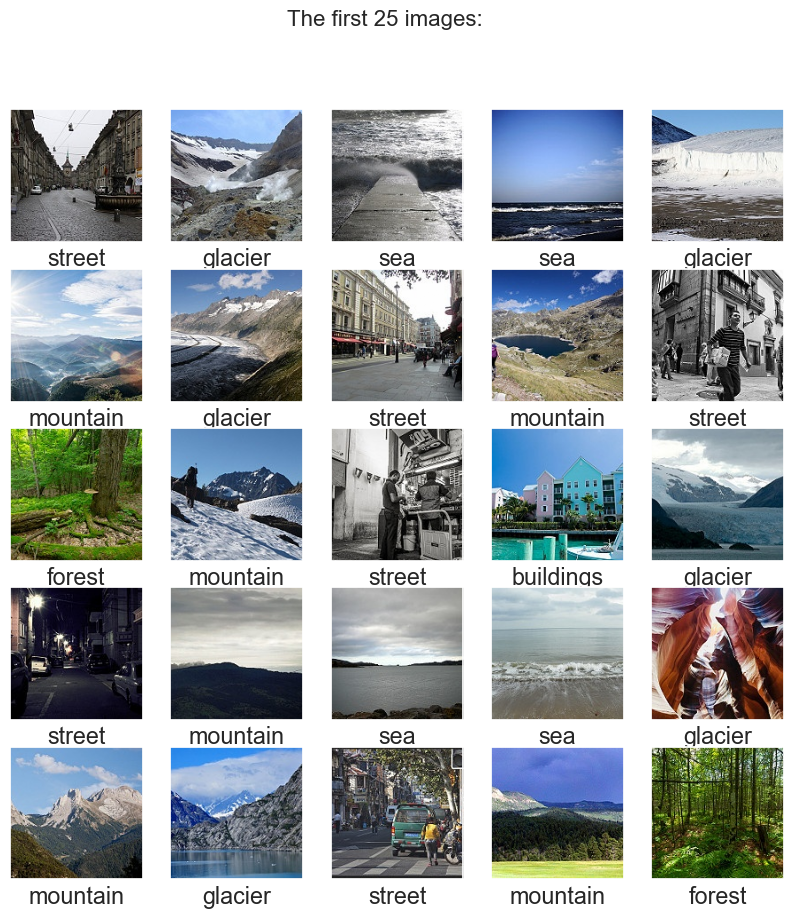

In [214]:
display_examples(class_names, train_images, train_labels)

Now we specify the model, using slightly different syntax than before. We define a Convolutional Neural Network (CNN) model using TensorFlow's Keras API. The model is initialized as a `Sequential()` object; the first layer is a `Conv2D` layer, which applies 32 convolutional filters of size 3 x 3 to the input images. This layer uses the ReLU activation function, which helps the model learn non-linear patterns in the data. The input shape for this layer is specified as `(150, 150, 3)`, corresponding to images that are 150 x 150 pixels with 3 color channels (RGB).

After the first convolutional layer, a `MaxPooling2D` layer with a pool size of 2 x 2 is applied. This operation reduces the spatial dimensions (height and width) of the feature maps, helping the model focus on the most important features while reducing computational complexity. Next, we add a second `Conv2D` layer with 32 filters of size 3 x 3 and another `MaxPooling2D` layer, following the same structure as the previous layers. These two layers can extract higher-level features from the input images, with the pooling layers further reducing the spatial size. The `Flatten()` layer is then used to reshape the 2D feature maps from the convolutional and pooling layers into a 1D vector, making it suitable for the fully connected (dense) layers that follow.

The first fully connected layer is a `Dense` layer with 128 units and a ReLU activation function. This layer processes the learned features and prepares them for the final classification layer. The final layer of the model is another `Dense` layer with 6 units, which corresponds to the 6 possible classes in the dataset. The softmax activation function is used here, which outputs a probability distribution over the 6 classes. This means the model will output the likelihood that an input image belongs to each of the 6 categories.

Finally, `model.summary()` prints a summary of the model's architecture, including the number of parameters at each layer and the total number of parameters in the model.

In [215]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,319,462 (20.29 MB)

 Trainable params: 5,319,462 (20.29 MB)

 Non-trainable params: 0 (0.00 B)

In this code, the model is compiled using the `compile() method, which configures the model for training by specifying the optimizer, loss function, and evaluation metrics.

We use "Adam" here, as before, but now the loss function used is 'sparse_categorical_crossentropy'. This loss function is also suitable for multi-class classification problems where each class is represented by a single integer label (not one-hot encoded). It calculates the difference between the predicted probability distribution (from the softmax layer) and the true class labels, which are expected to be integers representing the correct class index.

Now the model is ready to be trained on the dataset.

In [216]:
model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics=['accuracy'])

Now we train the model using the `fit()` method, which trains the model on the provided dataset and updates its weights based on the backpropagation algorithm. The batch size is set to 128, meaning that the model will process 128 samples at a time before updating its weights. A batch size determines how many training examples the model uses to calculate the gradient during each update. Larger batch sizes generally make training faster, but smaller batch sizes may improve the model's ability to generalize to unseen data.

The `validation_split` is set to $0.2$, which means that 20% of the training data will be used for validation during training. The model will evaluate its performance on this validation subset after each epoch, allowing it to track how well it generalizes to unseen data. The remaining 80% of the data is used for training the model. `epochs` is set to $5$. As before, running the model for more epochs would likely allow it to achieve better performance, but more epochs also increases the computation time.

The result of this training process is stored in the history variable, which contains information about the model's performance during each epoch, such as the training loss and accuracy, as well as the validation loss and accuracy. This history can be used to monitor the model's progress and adjust hyperparameters if needed.

In [217]:
history = model.fit(train_images, train_labels, 
                    batch_size=128, epochs=5, 
                    validation_split = 0.2)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.3837 - loss: 1.7367 - val_accuracy: 0.6737 - val_loss: 0.8926
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.6981 - loss: 0.8277 - val_accuracy: 0.7054 - val_loss: 0.7858
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.7561 - loss: 0.6702 - val_accuracy: 0.7097 - val_loss: 0.7613
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.8071 - loss: 0.5524 - val_accuracy: 0.7496 - val_loss: 0.7128
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.8529 - loss: 0.4356 - val_accuracy: 0.7560 - val_loss: 0.7240


Below, we define a function `plot_accuracy_loss(history)` that visualizes the training and validation accuracy, as well as the training and validation loss, during the training process. The function takes `history` as input, which is the object returned by the `fit()` method when the model is trained. This object contains the training and validation performance metrics (accuracy and loss) for each epoch.

For the accuracy plot, both training and validation accuracy are displayed. The training accuracy is shown with blue circles (`'bo--'`), and the validation accuracy is shown with red circles (`'ro--'`). The x-axis represents the number of epochs, while the y-axis represents the accuracy. For the loss plot, both training and validation loss are plotted, in the same fashion.

These plots provide a visual representation of the model's performance during training. By comparing the training and validation accuracy/loss, you can observe how well the model is learning and whether it is overfitting (i.e., when the validation performance diverges from the training performance).

In [218]:
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

We call the function. As expected, accuracy tends to decrease as the number of epochs increases, for both training and validation sets (although validation accuracy tends to taper off). Training loss tends to decrease as the number of epochs increases; validation loss starts to go back up a bit, indicating possible overfitting.

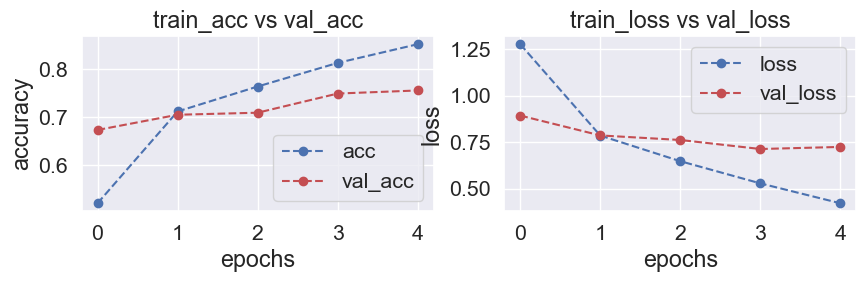

In [219]:
plot_accuracy_loss(history)

We now assess the model's accuracy and loss on the testing data set:

In [220]:
test_accuracy = model.evaluate(test_images, test_labels)

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8102 - loss: 0.5647


This is not bad accuracy, considering the six classes of our outcome and only five epochs that we ran the model for.

Let's explore the model's predictions a bit further. Notice that we didn't do this with the first dataset, although we could! The below code obtains our model's predictions of the test set using the`predict()` method. Since the model is performing multi-class classification, the output of `predict()` is a vector of probabilities for each class for every image. Each element in the vector represents the model's confidence (probability) that the image belongs to each class.

The resulting `predictions` array contains these probability vectors, where each entry corresponds to one image in the `test_images` dataset. Next, `np.argmax(predictions, axis=1)` is used to convert these probability vectors into discrete class labels. The `np.argmax()` function returns the index of the highest probability in each vector, which corresponds to the predicted class label for each image. The `axis=1` argument specifies that the operation should be applied to each row (each image) in the predictions array, resulting in a 1D array of predicted class labels. The `pred_labels` variable now contains the predicted class labels for the test images, which can be compared with the true labels to evaluate the performance of the model.

In [221]:
predictions = model.predict(test_images)     # vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # we take the highest probability

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step


We can now use the `display_random_image` function we created earlier to pull out an example image from the testing dataset and see what label the model predicted for that image!

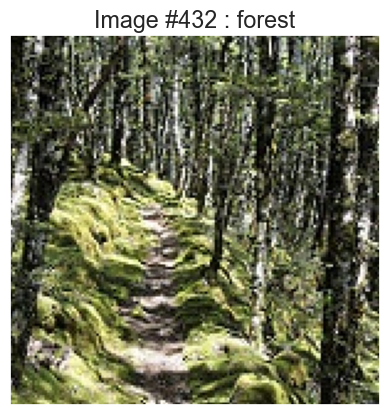

In [231]:
display_random_image(class_names, test_images, pred_labels)

If you re-run that code a few times, each time it will select a different image at random, with different results; sometimes the model will get it right, sometimes it will get it wrong.

We might then instinctively be curious about which times the model gets it wrong. Are there certain classes that it is worse at identifying correctly? Let's try and explore that a little bit. This code defines a function `print_mislabeled_images(class_names, test_images, test_labels, pred_labels)` that identifies and displays images that were misclassified by the model, along with their predicted labels.

The first line of the function, `BOO = (test_labels == pred_labels)`, creates a boolean array `BOO`, where each element is `True` if the predicted label matches the true label and `False` if they do not match. This comparison is done element-wise between the `test_labels` (true labels) and `pred_labels` (predicted labels). Next, `np.where(BOO == 0)` is used to find the indices where the boolean array `BOO` is `False`— i.e., where the labels don't match. These indices correspond to the misclassified images. The misclassified images are then extracted, along with their predicted labels, and displayed. We display the first 25 mislabeled images.

In [232]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):

    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    display_examples(class_names,  mislabeled_images, mislabeled_labels)

We can see a pattern here, in that many images of forests were misclassified as streets or buildings. In a way, this actually makes sense; forests tend to have a lot of vertical lines (trees), as do city streets.

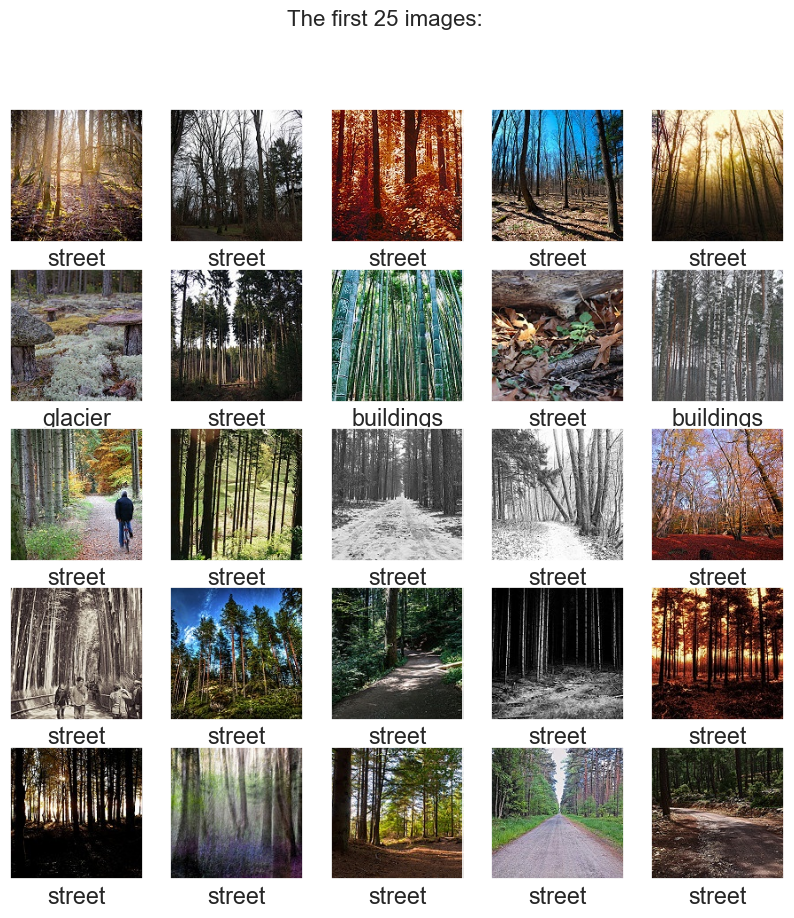

In [233]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

Let's go one step further and create a confusion matrix. The code below does that and then visualizes the matrix as a heat map, with lighter-colored regions for higher counts and darker colors for lower counts. This visually represents how well the model performed for each class, showing where it was able to correctly classify images (diagonal values) and where it confused different classes (off-diagonal values). This helps in identifying specific classes that the model struggles with and is useful for evaluating the overall performance of the model.

We apply it to the testing data:

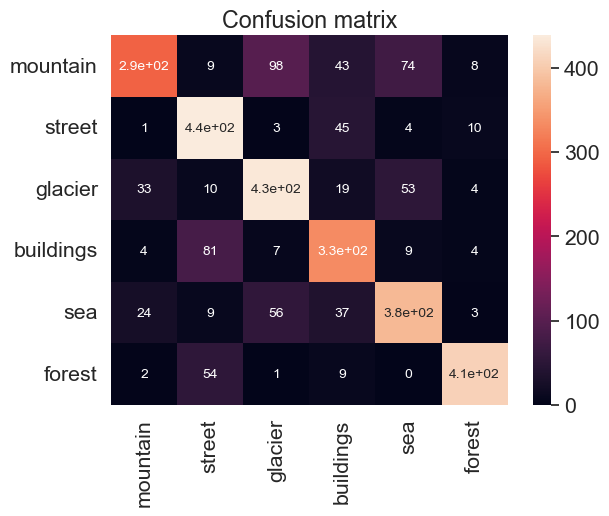

In [234]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

The diagonal counts are highest, which is good! We can also see some higher counts in the off-diagonals; there are $54$ forest images misclassified as "street," which we noticed earlier, for example. There are quite a few buildings misclassified as "street" as well, which makes a lot of sense, and $56$ sea images misclassified as "glacier."

### Exercises

4. Try writing a function similar to our `generate_predictions` function from earlier to discover what our model predicts for a new image that you've found on the Internet. Can it correctly classify the new image?
5. Try adding a dropout layer to this model, with $0.25$. What, if any, differences do you notice?
6. Create a confusion matrix like this for our vegetable classification example. Which classes of vegetable was that model better and/or worse at identifying? How do you know?

## References

[Vegetable image classification dataset](https://www.researchgate.net/publication/352846889_DCNN-Based_Vegetable_Image_Classification_Using_Transfer_Learning_A_Comparative_Study)

[Tutorial on vegetable image classification](https://www.kaggle.com/code/chitwanmanchanda/vegetable-image-classification-using-cnn/notebook)

[Intel image classification dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)

[Tutorial on Intel image classification](https://www.kaggle.com/code/vincee/intel-image-classification-cnn-keras)